In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
import random
import pandas as pd #used to manipulate csv files

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [0]:
#loading and unpickling the data 

with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
     
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f) 

  
  
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f) 


X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [0]:
#verifying if th edata is correct or not

assert(X_train.shape[0] == y_train.shape[0]), 'The number of images is not equal to the number of labels for the training dataset'
assert(X_test.shape[0] == y_test.shape[0]), 'The number of images is not equal to the number of labels for the testing dataset'
assert(X_val.shape[0] == y_val.shape[0]), 'The number of images is not equal to the number of labels for the validation dataset'

assert(X_train.shape[1:] == (32,32,3)), 'The dimensions of the images are not 32 x 32 x 3 for the training dataset'
assert(X_test.shape[1:] == (32,32,3)), 'The dimensions of the images are not 32 x 32 x 3 for the testing dataset'
assert(X_val.shape[1:] == (32,32,3)), 'The dimensions of the images are not 32 x 32 x 3 for the validation dataset'

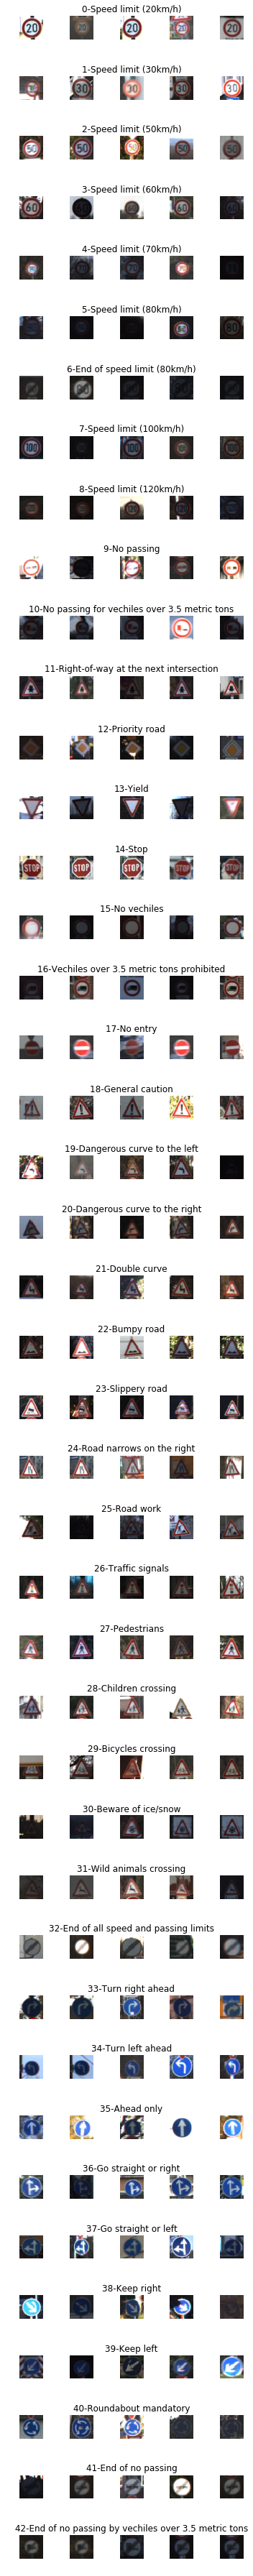

In [0]:
#CHECK the data is correct!
#plotting and analysing the data

data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


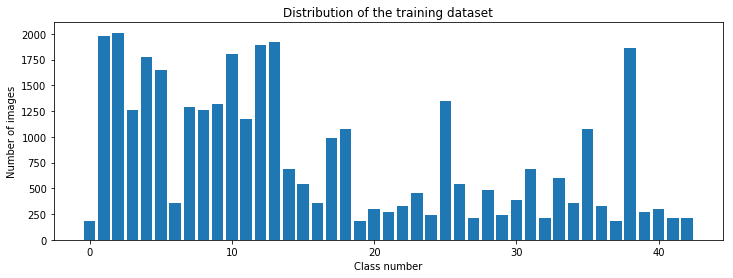

In [0]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


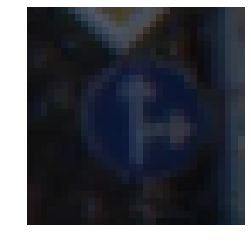

In [0]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])
#PRE PROCCESSING TECHNIQUES (PPT)

(32, 32)


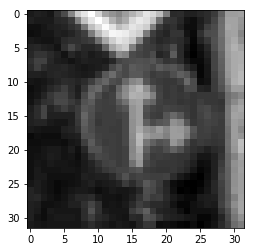

In [0]:
#PPT-1 (Grayscale)

def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap=plt.get_cmap("gray"))
print(img.shape)

(32, 32)


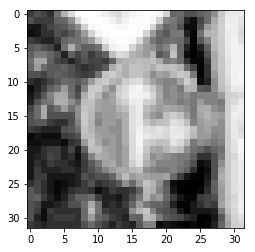

In [0]:
#PPT-2 (Histogram Equalisation)

def equalise(img):
  img = cv2.equalizeHist(img)
  return img

img = equalise(img)
plt.imshow(img, cmap=plt.get_cmap("gray"))
print(img.shape)

In [0]:
def preproccesing(img):
  img = grayscale(img)
  img = equalise(img)
  #PPT -3 (Normalisation)
  img = img/255
  return img
  
#Pre-processing the datasets
X_train = np.array(list(map(preproccesing, X_train)))
X_test = np.array(list(map(preproccesing, X_test)))
X_val = np.array(list(map(preproccesing, X_val)))


(34799, 32, 32)


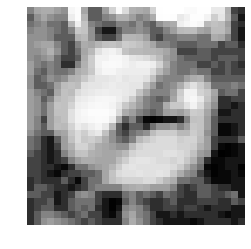

In [0]:
#CHECK preprocessing work!
plt.imshow(X_train[random.randint(0,len(X_train) - 1)], cmap=plt.get_cmap("gray"))
plt.axis("off")
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [0]:
#DATA AUGMENTATION
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.2,
                              shear_range=0.1,
                              rotation_range=10)
data_gen.fit(X_train)

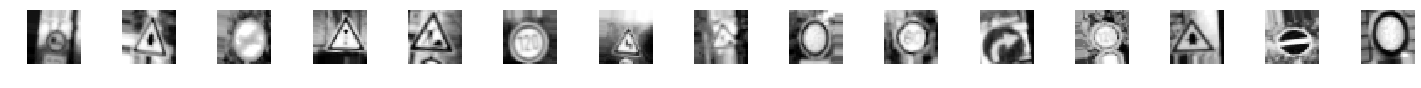

In [0]:
#creating batches of te augmented data
batches = data_gen.flow(X_train, y_train, batch_size =20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1,15, figsize = (20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32), cmap = plt.get_cmap('gray'))
  axs[i].axis("off")


In [0]:
#encoding the data labels in a "0 and 1" format because of multi classification
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
#SYSTEM ARCHITECTURE

def model():
  model = Sequential()

  model.add(Conv2D(filters = 60, kernel_size = (5,5), input_shape = (32,32,1), activation = 'relu'))
  model.add(Conv2D(filters = 60, kernel_size = (5,5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  #model.add(Dropout(0.6))

  model.add(Flatten())

  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.6))
  model.add(Dense(num_classes, activation = 'softmax'))

  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model



Fine tuning done 
1. decreased lr by a factor of 10
2. doubled the no of filters in each convolutional layer
3. doubled the no of convolutional layers 
4. added more dropout layer(s)
5. removed a dropout layer

In [0]:
model = model()
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0        

In [0]:
#training the model

history = model.fit_generator(data_gen.flow(X_train,y_train, batch_size =50), steps_per_epoch=2000, epochs=12,validation_data=(X_val,y_val), shuffle = 1 )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/12
2000/2000 [==============================] - 59s 29ms/step - loss: 0.9421 - acc: 0.7240 - val_loss: 0.0749 - val_acc: 0.9766
Epoch 2/12
2000/2000 [==============================] - 51s 26ms/step - loss: 0.2273 - acc: 0.9286 - val_loss: 0.0463 - val_acc: 0.9850
Epoch 3/12
2000/2000 [==============================] - 52s 26ms/step - loss: 0.1583 - acc: 0.9515 - val_loss: 0.0470 - val_acc: 0.9859
Epoch 4/12
2000/2000 [==============================] - 52s 26ms/step - loss: 0.1212 - acc: 0.9626 - val_loss: 0.0886 - val_acc: 0.9814
Epoch 5/12
2000/2000 [==============================] - 52s 26ms/step - loss: 0.1031 - acc: 0.9686 - val_loss: 0.0526 - val_acc: 0.9828
Epoch 6/12
2000/2000 [==============================] - 52s 26ms/step - loss: 0.0892 - acc: 0.9726 - val_loss: 0.0525 - val_acc: 0.9846
Epoch 7/12
2000/2000 [==============================] - 52s 26ms/step - loss: 0.0842 - acc

Text(0.5, 0, 'epochs')

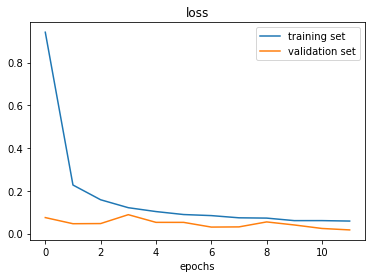

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training set', 'validation set'])
plt.title('loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

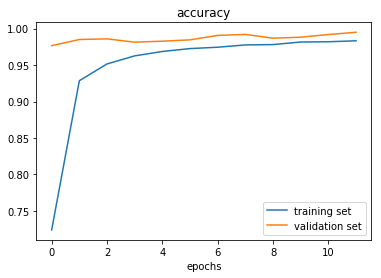

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training set', 'validation set'])
plt.title('accuracy')
plt.xlabel('epochs')

In [0]:
#test set

score = model.evaluate(X_test, y_test, verbose = 0)

print("Test Score = ",score[0])
print("Test Acc   = ",score[1]*100,"%")


Test Score =  0.09230122253357176
Test Acc   =  97.85431512461139 %


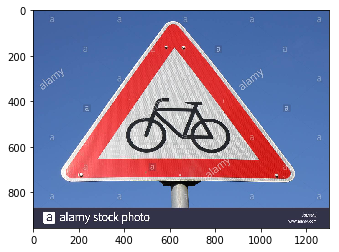

In [0]:
#testing with images from the internet and not the data repository

#fetching the image
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


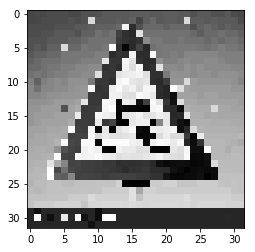

In [0]:
#preprocessing the image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preproccesing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 

In [0]:
#predicting the image
img = img.reshape(1, 32, 32, 1)
print('predicted sign: '+ str(model.predict_classes(img)))

predicted sign: [29]
